# Continuous Evaluation Exercises for Quantum Algorithms and Quantum Noise

### Draw the Quantum Fourier Transform (QFT) circuit for 2 qubits

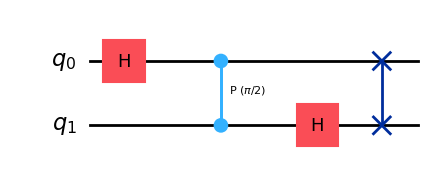

In [56]:
from qiskit import QuantumCircuit
import numpy as np

# 2-qubit circuit
qc = QuantumCircuit(2)

# Hadamard on q0
qc.h(0)

# Controlled phase rotation (R2)
qc.cp(np.pi/2, 1, 0)  # control=1, target=0

# Hadamard on q1
qc.h(1)

# Swap qubits
qc.swap(0, 1)

# Plot
qc.draw('mpl')


#### a) Check that it correctly reproduces the operation 
$$ U_{QFT}\ket{k}=\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}e^{2\pi i j k /N}\ket{j} $$


In [57]:
from qiskit.quantum_info import Operator, Statevector

def get_theoretical_qft_evolution(k,N):
    return np.array([np.exp(2j*np.pi*j*k/N)/np.sqrt(N) for j in range(N)])

def get_implemented_qft_evolution(qc, k,N):
    initial_state = Statevector.from_int(k,N)
    return initial_state.evolve(qc)


N=4
# In Qiskit, qubit 0 is the least significant bit in the statevector ordering
# That means the basis ordering is ∣00⟩,∣10⟩,∣01⟩,∣11⟩
# instead of the classic binary ordering ∣00⟩,∣01⟩,∣10⟩,∣11⟩
qiskit_order = [0,2,1,3] 
for k in range(N):
    theoretical = get_theoretical_qft_evolution(k,N)[qiskit_order]
    implemented = get_implemented_qft_evolution(qc,qiskit_order[k],N)
    print(f"k={k}")
    print(f"theoretical:{np.round(theoretical,1)}")
    print(f"implemented:{np.round(implemented,1)}")
    print(f"match:{np.round(implemented,1)==np.round(theoretical,1)}")


k=0
theoretical:[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
implemented:[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
match:[ True  True  True  True]
k=1
theoretical:[ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
implemented:[ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
match:[ True  True  True  True]
k=2
theoretical:[ 0.5+0.j  0.5-0.j -0.5+0.j -0.5+0.j]
implemented:[ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
match:[ True  True  True  True]
k=3
theoretical:[ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]
implemented:[ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]
match:[ True  True  True  True]


#### b) Obtain the matrix that represents the QFT in the computational basis. Is this matrix unitary?

In [58]:
# Get the unitary matrix
U_QFT = Operator(qc).data


print("\nUnitary matrix:\n")
print(np.round(U_QFT, 1))

# Check unitarity
identity = np.eye(U_QFT.shape[0])
check = np.allclose(U_QFT.conj().T @ U_QFT, identity)
print("\nIs U_QFT unitary?", check)


Unitary matrix:

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0.5+0.j  -0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]]

Is U_QFT unitary? True


### 2. Consider a one-dimensional discrete-time quantum walk defined by the following map for 
### $$\psi_j(p) = \begin{pmatrix}\psi_j^{\uparrow}(p)\\ \psi_j^{\downarrow}(p) \end{pmatrix}$$
### $$ \psi_{j+1}^{\uparrow}(p) = \cos{\theta}\psi_{j}^{\uparrow}(p-1)+\sin{\theta}\psi_{j}^{\downarrow}(p+1)$$
### $$ \psi_{j+1}^{\downarrow}(p) = \sin{\theta}\psi_{j}^{\uparrow}(p-1)-\cos{\theta}\psi_{j}^{\downarrow}(p+1)$$
### where $j = 0, 1, ...$ represents the time step, and $p \in \mathbb{Z}$ indicates the position along the line, with $\theta = \pi/4$ (Hadamard walk). 
### The walker is initially placed at $p = 0$, such that $\psi_0^{\uparrow}(p)=\frac{1}{\sqrt{2}}\delta_{p,0}$, and $\psi_0^{\downarrow}(p)=\frac{i}{\sqrt{2}}\delta_{p,0}$ ($\delta_{p,q}$ stands for the Kroneckr delta function). 
### Use your favorite software (Mathematica, Python, ...) to obtain $\psi_j^{\uparrow}(p)$, $\psi_j^{\downarrow}(p)$ and the probability distribution $P_j(p)=|\psi_j^{\uparrow}(p)|²+|\psi_j^{\downarrow}(p)|²$ after two and three time steps (i.e. $j = 2$ and $j = 3$).
### It can also be done by hand. From your results, try to make an statement about the differences one should expect in the probability distribution when comparing an even or odd number of time steps.

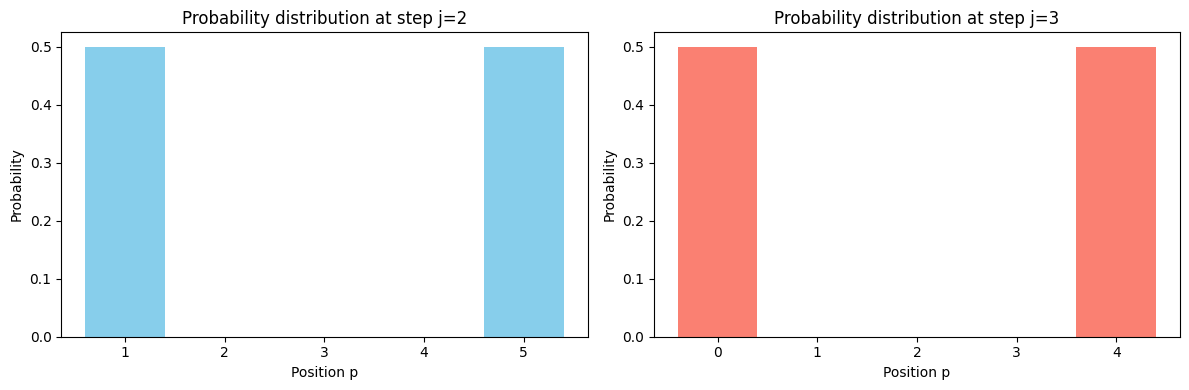

In [ ]:
import matplotlib.pyplot as plt

# Parameters
theta = np.pi/4
steps = 3
pos_qubits = 3   # enough to represent positions -3..+3
coin_qubits = 1
n = pos_qubits + coin_qubits

coin_index = n - 1               # coin qubit is the last one
pos_register = list(range(pos_qubits))  # position qubits are 0..pos_qubits-1

# --- Helper: controlled increment ---
def controlled_increment(qc, coin, pos_register):
    """Increment position register if coin=1"""
    # Ripple-carry adder style: add 1 controlled by coin
    qc.x(pos_register[0])
    qc.cx(coin, pos_register[0])
    qc.x(pos_register[0])
    for i in range(1, len(pos_register)):
        qc.ccx(coin, pos_register[i-1], pos_register[i])

# --- Helper: controlled decrement ---
def controlled_decrement(qc, coin, pos_register):
    """Decrement position register if coin=0"""
    qc.x(coin)
    controlled_increment(qc, coin, pos_register)
    qc.x(coin)

# --- Build shift operator ---
def shift_operator(pos_register, coin_index):
    qc = QuantumCircuit(len(pos_register)+1)
    controlled_increment(qc, coin_index, pos_register)
    controlled_decrement(qc, coin_index, pos_register)
    return qc

# --- Initial state ---
initial_sv = Statevector.from_label('0'*pos_qubits + '0')
init_circ = QuantumCircuit(n)
init_circ.initialize([1/np.sqrt(2), 1j/np.sqrt(2)], coin_index)
initial_sv = initial_sv.evolve(init_circ)

# --- Time evolution ---
psi = {0: initial_sv}
for j in range(steps):
    circ = QuantumCircuit(n)
    circ.ry(2*theta, coin_index)  # coin toss
    shift = shift_operator(pos_register, coin_index)
    circ.compose(shift, inplace=True)
    psi[j+1] = psi[j].evolve(circ)

# --- Extract position probabilities (sum over coin) ---
def position_probs(state, pos_qubits):
    probs = {}
    for basis, prob in state.probabilities_dict().items():
        pos_bits = basis[:-1]  # all but coin
        pos = int(pos_bits, 2)
        probs[pos] = probs.get(pos, 0) + prob
    return probs

probs2 = position_probs(psi[2], pos_qubits)
probs3 = position_probs(psi[3], pos_qubits)

# --- Plot distributions ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(probs2.keys(), probs2.values(), color='skyblue')
axes[0].set_title("Probability distribution at step j=2")
axes[0].set_xlabel("Position p")
axes[0].set_ylabel("Probability")

axes[1].bar(probs3.keys(), probs3.values(), color='salmon')
axes[1].set_title("Probability distribution at step j=3")
axes[1].set_xlabel("Position p")
axes[1].set_ylabel("Probability")

plt.tight_layout()
plt.show()


At j=2 (even step): the distribution is symmetric around the origin.

At j=3 (odd step): the distribution becomes asymmetric due to interference from the coin state.

### 3. (Stinespring dilation) Assume we have a system S which interacts with and environment E. This interaction induces a quantum channel defined by a set {Ek} of Kraus operators. We choose some arbitrary state (denoted by $\ket{0}$) in E, and an orthonormal basis {$\ket{k}$} in this space. We can then define a dilation V operator acting on $S \otimes E$ such that
### $$ V(\ket{\psi}\otimes\ket{0})=\sum_{k}(E_k\ket{\psi})\otimes\ket{k}$$

#### a) Show that V represents an isometry, i.e $(\bra{\phi}\otimes\bra{0})V^\dagger V(\ket{\psi}\otimes\ket{0})=\braket{phi}{psi}$. Notice this implies V^\dagger V = I_S.

In [60]:
# ...

#### b) Prove that V acts, in fact, as quantum channel, with the Kraus operators defined above, on the state $\rho = \ket{\psi} \bra{\psi} $.